## Failure ratio of master jobs
Jobs initiated in the last 24h

In [1]:
%matplotlib inline
import sys
import os
import datetime, calendar
import azure.cosmos.cosmos_client as cosmos_client
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
client = cosmos_client.CosmosClient(url_connection=os.environ['endpoint'], auth={'masterKey': os.environ['masterKey']})

database_link = 'dbs/' + os.environ['databaseId']
collection_link = database_link + '/colls/{}'.format(os.environ['containerId'])

In [42]:
last_sunday = datetime.date.today()
one_day = datetime.timedelta(days=1)
one_week = datetime.timedelta(days=7)

while last_sunday.weekday() != calendar.SUNDAY:
    last_sunday -= one_day
    
# Number of weeks we want to go back in
weeks_in_past = 2
    
reversed_sundays = list(
    map(
        lambda week: (last_sunday - (week * one_week)).isoformat(),
        range(weeks_in_past)
    )
)

sundays = reversed_sundays[::-1]

sundays

first_sunday, *tail_sundays = sundays

query = {
    "query": """
     SELECT c.job_name, c.build_id, c.current_build_current_result, c.stage_timestamp, c._ts
     FROM c
     WHERE c.current_build_scheduled_time > '{0}Z'
         and c.branch_name = 'master'
    """.format(first_sunday)
}

query_results = list(client.QueryItems(collection_link, query))

df = pd.DataFrame(query_results)

df

,job_name,build_id,current_build_current_result,stage_timestamp,_ts
0,HMCTS_Nightly_Probate/probate-intestacy-e2e-te...,89,SUCCESS,2019-10-07T01:00:27Z,1570410028
1,HMCTS_Nightly_Probate/probate-intestacy-e2e-te...,89,SUCCESS,2019-10-07T01:01:42Z,1570410102
2,HMCTS_Nightly_Probate/probate-intestacy-e2e-te...,89,SUCCESS,2019-10-07T01:01:43Z,1570410103
3,HMCTS_Nightly_Probate/probate-intestacy-e2e-te...,89,FAILURE,2019-10-07T01:09:24Z,1570410565
4,HMCTS_Nightly_Probate/probate-intestacy-e2e-te...,89,FAILURE,2019-10-07T01:10:14Z,1570410614
...,...,...,...,...,...
17830,HMCTS_SSCS/sscs-submit-your-appeal/master,99,SUCCESS,2019-10-18T14:18:05Z,1571408285
17831,HMCTS_RPA/rpa-coh-continuous-online-resolution...,41,FAILURE,2019-10-18T14:18:09Z,1571408289
17832,HMCTS_RPA/rpa-coh-continuous-online-resolution...,41,FAILURE,2019-10-18T14:18:11Z,1571408291
17833,HMCTS_SSCS/sscs-submit-your-appeal/master,99,SUCCESS,2019-10-18T14:20:05Z,1571408405


In [57]:
# For the past week:

past_week_df = df[(df['stage_timestamp'] > sundays[0]) & (df['stage_timestamp'] < sundays[1])]

past_week_df

last_builds = pd.DataFrame(
    past_week_df
        .sort_values(by='stage_timestamp')
        .drop_duplicates('job_name', keep='last')
)

last_builds

,job_name,build_id,current_build_current_result,stage_timestamp,_ts
876,HMCTS_RPA/rpa-coh-continuous-online-resolution...,37,FAILURE,2019-10-07T10:05:15Z,1570442715
1908,HMCTS_CDM/ccd-user-profile-api/master,23,SUCCESS,2019-10-07T18:05:00Z,1570471500
1931,HMCTS_DIV/div-health-monitor/master,12,SUCCESS,2019-10-07T20:14:38Z,1570479278
2470,HMCTS_Platform/draft-store/master,146,SUCCESS,2019-10-08T09:19:11Z,1570526351
2911,HMCTS_CDM/ccd-definition-store-api/master,40,SUCCESS,2019-10-08T10:53:34Z,1570532014
...,...,...,...,...,...
10451,HMCTS_Nightly_IAC/ia-case-documents-api/master,113,FAILURE,2019-10-12T22:49:45Z,1570920585
10462,HMCTS_Nightly_FinRem/finrem-payment-service/ma...,101,FAILURE,2019-10-12T23:11:38Z,1570921898
10464,HMCTS_Nightly_FinRem/finrem-case-orchestration...,102,FAILURE,2019-10-12T23:17:53Z,1570922273
10466,HMCTS_Nightly_IAC/ia-ccd-e2e-tests/master,112,ABORTED,2019-10-12T23:31:01Z,1570923061


In [58]:
total_rows = len(last_builds)
successes = len(last_builds.loc[df['current_build_current_result'] == 'SUCCESS'])
failures = len(last_builds.loc[df['current_build_current_result'] == 'FAILURE'])
unknows = total_rows - successes - failures
success_ratio = round(successes/(successes + failures) * 100)


Success Ratio: 54%




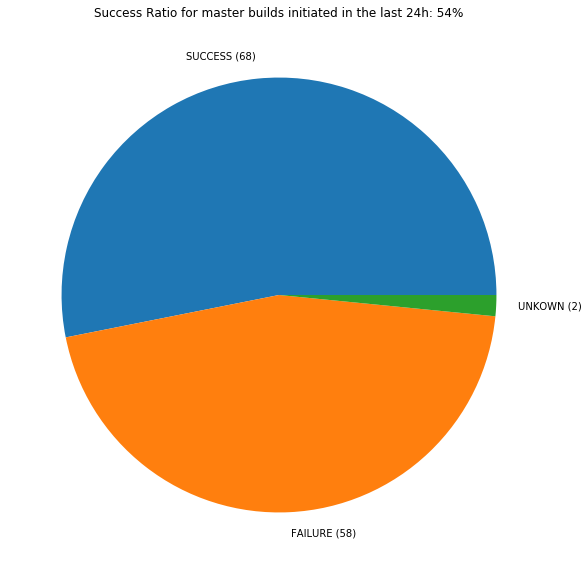

In [59]:
print('')
print('Success Ratio: {0}%'.format(success_ratio))
print('')

statuses = [successes, failures, unknows]
labels = ['SUCCESS',
          'FAILURE',
          'UNKOWN']

labels_with_amounts = list(
    map(
        lambda status, label: '{0} ({1})'.format(status, label),
        labels,
        statuses
    )
)

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.pie(statuses, labels=labels_with_amounts)
ax.set_title('Success Ratio for master builds initiated in the last 24h: {0}%'.format(success_ratio))
print('')